# BERT Fine-tuning for Fake News Detection on LIAR Dataset

This notebook implements an enhanced BERT model with additional LSTM and attention layers for fake news detection using the LIAR dataset. The model incorporates metadata features and uses advanced techniques like class balancing and gradient accumulation for improved performance.

## Features:
- Enhanced BERT architecture with LSTM and multi-head attention
- Metadata integration (speaker, subject, context)
- Class balancing for imbalanced data
- Comprehensive evaluation and visualization
- Model saving and loading capabilities

## 1. Install Required Libraries

Install all necessary Python packages for deep learning, data processing, and visualization.

In [1]:
# Install required libraries
!pip install transformers torch torchvision torchaudio
!pip install datasets scikit-learn matplotlib seaborn
!pip install accelerate
!pip install wandb  # Optional for experiment tracking

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2. Import Libraries and Set Random Seeds

Import all required libraries and set random seeds for reproducible results.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    BertTokenizer, BertModel, BertConfig,
    get_linear_schedule_with_warmup,
    AutoTokenizer, AutoModel
)
# from transformers.optimization import AdamW # Correct import for AdamW
from torch.optim import AdamW # AdamW is now in torch.optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_recall_fscore_support, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
import os
import random
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Libraries imported and random seeds set successfully!")

Libraries imported and random seeds set successfully!


## 3. Enhanced BERT Model Architecture

Define an enhanced BERT model with additional LSTM layers, multi-head attention, and classification layers for improved performance.

In [4]:
class EnhancedBertForSequenceClassification(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_classes=2, dropout=0.3):
        super().__init__()
        self.num_classes = num_classes
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)

        # Additional layers for better performance
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=512,  # bidirectional LSTM output
            num_heads=8,
            dropout=0.1
        )

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        # Layer normalization
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, input_ids, attention_mask):
        # BERT encoding
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get sequence output (all tokens)
        sequence_output = bert_output.last_hidden_state
        sequence_output = self.dropout(sequence_output)

        # LSTM layer
        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = self.layer_norm(lstm_output)

        # Self-attention
        lstm_output_transposed = lstm_output.transpose(0, 1)
        attn_output, _ = self.attention(
            lstm_output_transposed,
            lstm_output_transposed,
            lstm_output_transposed
        )
        attn_output = attn_output.transpose(0, 1)

        # Global max pooling
        pooled_output = torch.max(attn_output, dim=1)[0]

        # Classification
        logits = self.classifier(pooled_output)

        return logits

print("Enhanced BERT model class defined successfully!")

Enhanced BERT model class defined successfully!


## 4. Dataset Class Implementation

Create a custom PyTorch Dataset class for handling the LIAR dataset with text tokenization and metadata integration.

In [5]:
class LiarDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512, include_metadata=False, metadata=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.include_metadata = include_metadata
        self.metadata = metadata

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Add metadata context if available
        if self.include_metadata and self.metadata is not None:
            speaker = str(self.metadata['speaker'].iloc[idx])
            subject = str(self.metadata['subject'].iloc[idx])
            context = str(self.metadata['context'].iloc[idx])

            # Enhanced text with metadata
            enhanced_text = f"Statement: {text} Speaker: {speaker} Subject: {subject} Context: {context}"
        else:
            enhanced_text = text

        encoding = self.tokenizer(
            enhanced_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class implemented successfully!")

Dataset class implemented successfully!


## 5. Data Loading and Preprocessing

Implement functions to load the LIAR dataset from TSV files and preprocess the data with enhanced text features and label encoding.

In [6]:
def load_liar_dataset():
    """
    Download LIAR dataset from: https://github.com/thiagorainmaker77/liar_dataset
    Place train.tsv, valid.tsv, test.tsv in data/ folder
    """
    columns = [
        'label', 'statement', 'subject', 'speaker', 'job_title',
        'state_info', 'party_affiliation', 'barely_true_counts',
        'false_counts', 'half_true_counts', 'mostly_true_counts',
        'pants_on_fire_counts', 'context'
    ]

    # Update paths according to your data location
    train_df = pd.read_csv('/content/drive/MyDrive/liardataset/train.tsv', sep='\t', header=None, names=columns)
    val_df = pd.read_csv('/content/drive/MyDrive/liardataset/valid.tsv', sep='\t', header=None, names=columns)
    test_df = pd.read_csv('/content/drive/MyDrive/liardataset/test.tsv', sep='\t', header=None, names=columns)

    return train_df, val_df, test_df

def preprocess_liar_data(df, classification_type='binary'):
    """Enhanced preprocessing with metadata integration"""
    # Clean text data
    df['statement'] = df['statement'].astype(str).str.strip()
    df['context'] = df['context'].fillna('').astype(str)
    df['speaker'] = df['speaker'].fillna('Unknown').astype(str)
    df['subject'] = df['subject'].fillna('').astype(str)

    # Create enhanced text
    df['enhanced_text'] = (
        df['statement'] + ' [SEP] ' +
        'Speaker: ' + df['speaker'] + ' [SEP] ' +
        'Subject: ' + df['subject'] + ' [SEP] ' +
        'Context: ' + df['context']
    )

    # Label encoding
    if classification_type == 'binary':
        true_labels = ['mostly-true', 'true']
        df['encoded_label'] = df['label'].apply(lambda x: 1 if x in true_labels else 0)
        num_classes = 2
    else:  # 6-class
        label_map = {
            'pants-fire': 0, 'false': 1, 'barely-true': 2,
            'half-true': 3, 'mostly-true': 4, 'true': 5
        }
        df['encoded_label'] = df['label'].map(label_map)
        num_classes = 6

    return df, num_classes

print("Data loading and preprocessing functions defined successfully!")

Data loading and preprocessing functions defined successfully!


## 6. Process LIAR Dataset

Load the train, validation, and test datasets, apply preprocessing, and display data distribution statistics.

In [7]:
print("Loading LIAR dataset...")
train_df, val_df, test_df = load_liar_dataset()

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Choose classification type
CLASSIFICATION_TYPE = 'binary'  # or '6class'
train_df, num_classes = preprocess_liar_data(train_df, CLASSIFICATION_TYPE)
val_df, _ = preprocess_liar_data(val_df, CLASSIFICATION_TYPE)
test_df, _ = preprocess_liar_data(test_df, CLASSIFICATION_TYPE)

# Display label distribution
print("\nLabel distribution in training data:")
print(train_df['encoded_label'].value_counts().sort_index())

# Display sample data
print("\nSample data:")
print(train_df[['statement', 'speaker', 'subject', 'label', 'encoded_label']].head())

Loading LIAR dataset...
Train samples: 10240
Validation samples: 1284
Test samples: 1267

Label distribution in training data:
encoded_label
0    6602
1    3638
Name: count, dtype: int64

Sample data:
                                                    statement         speaker  \
2635.json   Says the Annies List political group supports ...    dwayne-bohac   
10540.json  When did the decline of coal start? It started...  scott-surovell   
324.json    Hillary Clinton agrees with John McCain "by vo...    barack-obama   
1123.json   Health care reform legislation is likely to ma...    blog-posting   
9028.json   The economic turnaround started at the end of ...   charlie-crist   

                                       subject        label  encoded_label  
2635.json                             abortion        false              0  
10540.json  energy,history,job-accomplishments    half-true              0  
324.json                        foreign-policy  mostly-true              1  
1123

## 7. Model Configuration and Setup

Define training configuration parameters, set up the device (GPU/CPU), and initialize the tokenizer.

In [8]:
# Configuration
CONFIG = {
    'model_name': 'bert-base-uncased',  # or 'distilbert-base-uncased' for faster training
    'max_length': 512,
    'batch_size': 16,  # Adjust based on GPU memory
    'learning_rate': 2e-5,
    'epochs': 4,
    'dropout': 0.3,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'gradient_accumulation_steps': 2,
}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

print(f"\nConfiguration set successfully!")
print(f"Model: {CONFIG['model_name']}")
print(f"Max length: {CONFIG['max_length']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Epochs: {CONFIG['epochs']}")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB

Configuration set successfully!
Model: bert-base-uncased
Max length: 512
Batch size: 16
Learning rate: 2e-05
Epochs: 4


## 8. Create Balanced Data Loaders

Create PyTorch DataLoaders with class balancing using weighted sampling to handle imbalanced data.

In [9]:
def create_balanced_data_loaders(train_df, val_df, tokenizer, config):
    """Create data loaders with class balancing"""

    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_df['encoded_label']),
        y=train_df['encoded_label']
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Create datasets
    train_dataset = LiarDataset(
        texts=train_df['enhanced_text'].values,
        labels=train_df['encoded_label'].values,
        tokenizer=tokenizer,
        max_length=config['max_length'],
        include_metadata=True,
        metadata=train_df[['speaker', 'subject', 'context']]
    )

    val_dataset = LiarDataset(
        texts=val_df['enhanced_text'].values,
        labels=val_df['encoded_label'].values,
        tokenizer=tokenizer,
        max_length=config['max_length'],
        include_metadata=True,
        metadata=val_df[['speaker', 'subject', 'context']]
    )

    # Weighted sampling for training
    train_labels = train_df['encoded_label'].values
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        sampler=sampler
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False
    )

    return train_loader, val_loader, class_weights_tensor

train_loader, val_loader, class_weights = create_balanced_data_loaders(
    train_df, val_df, tokenizer, CONFIG
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Class weights: {class_weights}")

Training batches: 640
Validation batches: 81
Class weights: tensor([0.7755, 1.4074], device='cuda:0')


## 9. Training Functions

Implement training and evaluation functions with gradient accumulation, loss calculation, and metrics tracking.

In [10]:
def train_epoch(model, train_loader, optimizer, scheduler, criterion, device, gradient_accumulation_steps):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc='Training')

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps

        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update progress bar
        current_accuracy = correct_predictions / total_predictions
        progress_bar.set_postfix({
            'loss': f'{total_loss / (step + 1):.4f}',
            'acc': f'{current_accuracy:.4f}'
        })

    return total_loss / len(train_loader), correct_predictions / total_predictions

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return total_loss / len(val_loader), accuracy, f1, all_predictions, all_labels, all_probabilities

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


## 10. Model Training Loop

Execute the main training loop with the enhanced BERT model, optimizer, scheduler, and early stopping based on validation F1 score.

In [11]:
# Initialize model
model = EnhancedBertForSequenceClassification(
    model_name=CONFIG['model_name'],
    num_classes=num_classes,
    dropout=CONFIG['dropout']
).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

total_steps = len(train_loader) * CONFIG['epochs'] // CONFIG['gradient_accumulation_steps']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

# Training loop
training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
best_model_state = None

print("Starting training...")
for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['epochs']}")
    print("-" * 50)

    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device,
        CONFIG['gradient_accumulation_steps']
    )

    # Validation
    val_loss, val_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion, device)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print(f"New best model saved! F1: {val_f1:.4f}")

    # Update history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print(f"\nTraining completed! Best validation F1: {best_val_f1:.4f}")

Total training steps: 1280
Warmup steps: 128
Starting training...

Epoch 1/4
--------------------------------------------------


Training:   0%|          | 0/640 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

New best model saved! F1: 0.5857
Train Loss: 0.6412, Train Acc: 0.5507
Val Loss: 0.6917, Val Acc: 0.5763, Val F1: 0.5857

Epoch 2/4
--------------------------------------------------


Training:   0%|          | 0/640 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

New best model saved! F1: 0.6105
Train Loss: 0.5539, Train Acc: 0.6999
Val Loss: 0.7210, Val Acc: 0.5989, Val F1: 0.6105

Epoch 3/4
--------------------------------------------------


Training:   0%|          | 0/640 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Train Loss: 0.4605, Train Acc: 0.7832
Val Loss: 0.8284, Val Acc: 0.5732, Val F1: 0.5800

Epoch 4/4
--------------------------------------------------


Training:   0%|          | 0/640 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

New best model saved! F1: 0.6482
Train Loss: 0.3993, Train Acc: 0.8320
Val Loss: 0.7818, Val Acc: 0.6371, Val F1: 0.6482

Training completed! Best validation F1: 0.6482


## 11. Training Visualization and Results

Create visualizations of training progress including loss curves, accuracy plots, and F1 score progression.

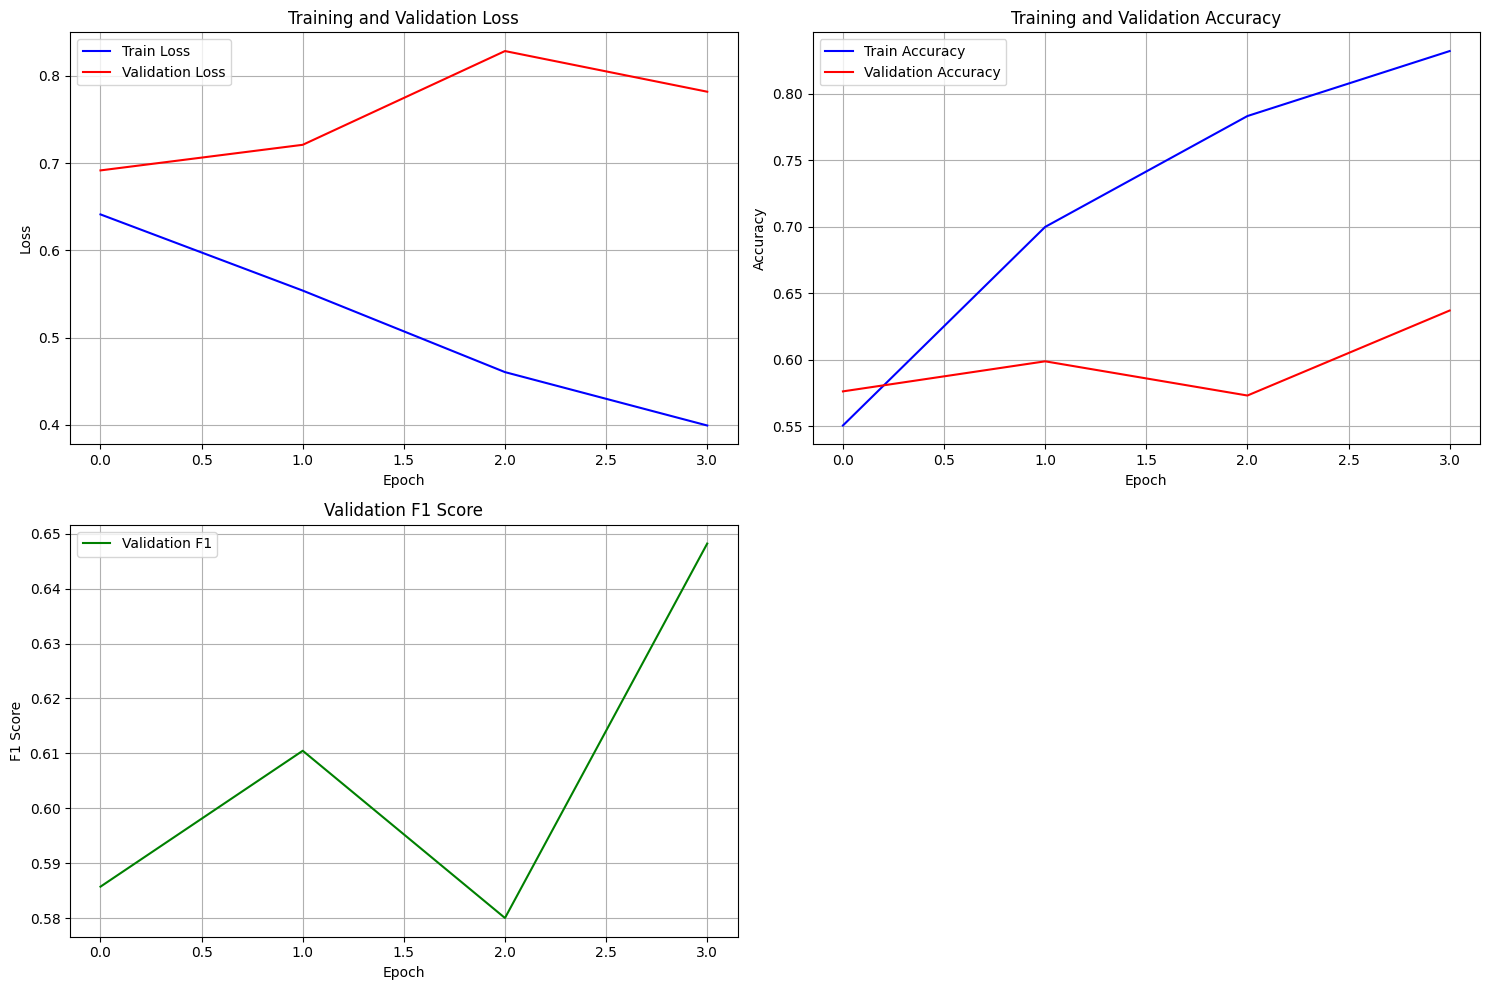


TRAINING SUMMARY
Best Validation F1 Score: 0.6482
Final Train Loss: 0.3993
Final Train Accuracy: 0.8320
Final Validation Loss: 0.7818
Final Validation Accuracy: 0.6371


In [12]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(training_history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy plots
axes[0, 1].plot(training_history['train_acc'], label='Train Accuracy', color='blue')
axes[0, 1].plot(training_history['val_acc'], label='Validation Accuracy', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 Score
axes[1, 0].plot(training_history['val_f1'], label='Validation F1', color='green')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Remove empty subplot
axes[1, 1].remove()

plt.tight_layout()
plt.show()

# Print training summary
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Best Validation F1 Score: {best_val_f1:.4f}")
print(f"Final Train Loss: {training_history['train_loss'][-1]:.4f}")
print(f"Final Train Accuracy: {training_history['train_acc'][-1]:.4f}")
print(f"Final Validation Loss: {training_history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {training_history['val_acc'][-1]:.4f}")

## 12. Test Set Evaluation

Evaluate the trained model on the test set and generate detailed classification reports and confusion matrices.

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Test Set Results:
Test Accuracy: 0.5975
Test F1 Score: 0.6061
Test Loss: 0.8160

Detailed Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.57      0.65       818
        True       0.45      0.65      0.53       449

    accuracy                           0.60      1267
   macro avg       0.60      0.61      0.59      1267
weighted avg       0.64      0.60      0.61      1267



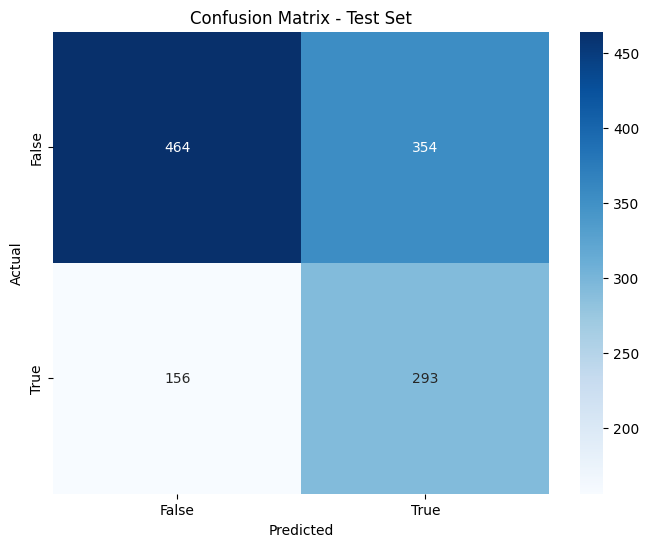

In [13]:
# Create test dataset
test_dataset = LiarDataset(
    texts=test_df['enhanced_text'].values,
    labels=test_df['encoded_label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['max_length'],
    include_metadata=True,
    metadata=test_df[['speaker', 'subject', 'context']]
)

test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Evaluate on test set
test_loss, test_acc, test_f1, test_predictions, test_labels, test_probabilities = evaluate(
    model, test_loader, criterion, device
)

print("Test Set Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Detailed classification report
if CLASSIFICATION_TYPE == 'binary':
    target_names = ['False', 'True']
else:
    target_names = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 13. Save Model and Tokenizer

Save the trained model state, configuration, and tokenizer for future use and deployment.

In [14]:
# Save the trained model
model_save_path = 'enhanced_bert_liar_model'
os.makedirs(model_save_path, exist_ok=True)

# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'num_classes': num_classes,
    'classification_type': CLASSIFICATION_TYPE,
    'class_weights': class_weights,
    'training_history': training_history,
    'test_metrics': {
        'accuracy': test_acc,
        'f1': test_f1,
        'loss': test_loss
    }
}, f'{model_save_path}/model.pth')

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}/")
print(f"✅ Model checkpoint saved successfully!")
print(f"📊 Test Accuracy: {test_acc:.4f}")
print(f"📊 Test F1 Score: {test_f1:.4f}")

Model saved to enhanced_bert_liar_model/
✅ Model checkpoint saved successfully!
📊 Test Accuracy: 0.5975
📊 Test F1 Score: 0.6061


## 14. Model Inference Function

Implement a prediction function for classifying new text statements as fake or real news.

In [15]:
def predict_fake_news(text, model, tokenizer, device, max_length=512):
    """
    Predict if a news statement is fake or real
    """
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    if CLASSIFICATION_TYPE == 'binary':
        label = 'Real' if predicted.item() == 1 else 'Fake'
        confidence_score = confidence.item()
    else:
        labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
        label = labels[predicted.item()]
        confidence_score = confidence.item()

    return {
        'prediction': label,
        'confidence': confidence_score,
        'probabilities': probabilities.cpu().numpy()[0]
    }

print("Prediction function defined successfully!")

Prediction function defined successfully!


## 15. Test Model Predictions

Test the trained model on sample statements to demonstrate inference capabilities and prediction confidence.

In [16]:
# Test the trained model
test_statements = [
    "The unemployment rate has dropped to its lowest level in 50 years.",
    "Scientists have discovered that vaccines cause autism in children.",
    "Climate change is a natural phenomenon and not caused by human activities.",
    "The economy is performing better than it has in decades."
]

print("Testing model predictions:")
print("=" * 60)

for i, statement in enumerate(test_statements, 1):
    result = predict_fake_news(statement, model, tokenizer, device)
    print(f"\nTest {i}:")
    print(f"Statement: {statement}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")

    if CLASSIFICATION_TYPE == 'binary':
        print(f"Probabilities: [Fake: {result['probabilities'][0]:.4f}, Real: {result['probabilities'][1]:.4f}]")

    print("-" * 40)

print("\nModel training and testing completed successfully!")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test F1 Score: {test_f1:.4f}")

Testing model predictions:

Test 1:
Statement: The unemployment rate has dropped to its lowest level in 50 years.
Prediction: Real
Confidence: 0.9022
Probabilities: [Fake: 0.0978, Real: 0.9022]
----------------------------------------

Test 2:
Statement: Scientists have discovered that vaccines cause autism in children.
Prediction: Fake
Confidence: 0.5094
Probabilities: [Fake: 0.5094, Real: 0.4906]
----------------------------------------

Test 3:
Statement: Climate change is a natural phenomenon and not caused by human activities.
Prediction: Real
Confidence: 0.6367
Probabilities: [Fake: 0.3633, Real: 0.6367]
----------------------------------------

Test 4:
Statement: The economy is performing better than it has in decades.
Prediction: Real
Confidence: 0.8904
Probabilities: [Fake: 0.1096, Real: 0.8904]
----------------------------------------

Model training and testing completed successfully!
Final Test Accuracy: 0.5975
Final Test F1 Score: 0.6061


## 16. Load Saved Model for Future Use

Implement functionality to load the saved model and tokenizer for inference in future sessions.

In [17]:
def load_saved_model(model_path='enhanced_bert_liar_model'):
    """
    Load the saved model for inference in future sessions
    """
    # Load checkpoint
    checkpoint = torch.load(f'{model_path}/model.pth', map_location=device)

    # Recreate model
    loaded_model = EnhancedBertForSequenceClassification(
        model_name=checkpoint['config']['model_name'],
        num_classes=checkpoint['num_classes'],
        dropout=checkpoint['config']['dropout']
    ).to(device)

    # Load state dict
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Load tokenizer
    from transformers import AutoTokenizer
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

    print(f"✅ Model loaded successfully from {model_path}")
    print(f"📊 Original test metrics:")
    print(f"   - Accuracy: {checkpoint['test_metrics']['accuracy']:.4f}")
    print(f"   - F1 Score: {checkpoint['test_metrics']['f1']:.4f}")

    return loaded_model, loaded_tokenizer, checkpoint

# Example usage (uncomment to test loading):
# loaded_model, loaded_tokenizer, checkpoint = load_saved_model()
#
# # Test prediction with loaded model
# test_text = "The economy is doing better than ever before."
# result = predict_fake_news(test_text, loaded_model, loaded_tokenizer, device)
# print(f"Prediction: {result['prediction']}")
# print(f"Confidence: {result['confidence']:.4f}")

print("Model loading function defined successfully!")

Model loading function defined successfully!


## 17. Dataset Analysis and Summary

Provide comprehensive analysis of the dataset including label distribution, text statistics, speaker diversity, and final model performance summary.

In [18]:
print("\n" + "="*60)
print("📊 DATASET ANALYSIS SUMMARY")
print("="*60)

# Label distribution analysis
print("\n🏷️  Label Distribution:")
train_label_dist = train_df['label'].value_counts()
for label, count in train_label_dist.items():
    percentage = (count / len(train_df)) * 100
    print(f"   {label:12}: {count:5d} samples ({percentage:5.1f}%)")

# Text length analysis
train_df['text_length'] = train_df['enhanced_text'].str.len()
print(f"\n📝 Text Length Statistics:")
print(f"   Average length: {train_df['text_length'].mean():.0f} characters")
print(f"   Median length:  {train_df['text_length'].median():.0f} characters")
print(f"   Max length:     {train_df['text_length'].max():.0f} characters")
print(f"   Min length:     {train_df['text_length'].min():.0f} characters")

# Speaker analysis
print(f"\n🗣️  Speaker Diversity:")
print(f"   Unique speakers: {train_df['speaker'].nunique()}")
print(f"   Top speakers:")
top_speakers = train_df['speaker'].value_counts().head()
for speaker, count in top_speakers.items():
    print(f"     {speaker}: {count} statements")

# Subject analysis
print(f"\n📚 Subject Diversity:")
print(f"   Unique subjects: {train_df['subject'].nunique()}")
print(f"   Top subjects:")
top_subjects = train_df['subject'].value_counts().head()
for subject, count in top_subjects.items():
    print(f"     {subject}: {count} statements")

print(f"\n🎯 Final Model Performance Summary:")
print(f"   Classification Type: {CLASSIFICATION_TYPE}")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1 Score: {test_f1:.4f}")
print(f"   Best Validation F1: {best_val_f1:.4f}")
print(f"   Model saved to: {model_save_path}/")

print(f"\n🔧 Model Architecture:")
print(f"   Base Model: {CONFIG['model_name']}")
print(f"   Additional Layers: LSTM + Multi-head Attention")
print(f"   Max Sequence Length: {CONFIG['max_length']}")
print(f"   Dropout: {CONFIG['dropout']}")
print(f"   Learning Rate: {CONFIG['learning_rate']}")

print("\n✅ Project completed successfully! 🎉")
print("\n💡 Next Steps:")
print("   - Use the model for real-time fake news detection")
print("   - Fine-tune with domain-specific data")
print("   - Implement in a web application or API")
print("   - Experiment with different model architectures")


📊 DATASET ANALYSIS SUMMARY

🏷️  Label Distribution:
   half-true   :  2114 samples ( 20.6%)
   false       :  1995 samples ( 19.5%)
   mostly-true :  1962 samples ( 19.2%)
   true        :  1676 samples ( 16.4%)
   barely-true :  1654 samples ( 16.2%)
   pants-fire  :   839 samples (  8.2%)

📝 Text Length Statistics:
   Average length: 216 characters
   Median length:  209 characters
   Max length:     3303 characters
   Min length:     78 characters

🗣️  Speaker Diversity:
   Unique speakers: 2911
   Top speakers:
     barack-obama: 488 statements
     donald-trump: 273 statements
     hillary-clinton: 239 statements
     mitt-romney: 176 statements
     scott-walker: 149 statements

📚 Subject Diversity:
   Unique subjects: 3828
   Top subjects:
     health-care: 381 statements
     taxes: 308 statements
     immigration: 253 statements
     elections: 252 statements
     education: 237 statements

🎯 Final Model Performance Summary:
   Classification Type: binary
   Test Accuracy: 0.